# Compare the GM-SEUS products (arrays & individual panels) to the existing collected dataproducts (USPVDB, CCPV, SAM, OSM, and OSM/CCPV panel shapes )

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

### Polygon comparison

   arrayID nativeID Source        area  instYr PnlSource  panelID  numPanels  \
0        0        0  CCVPV  106.764365  2018.0  existing   719587         25   
1        1     1568  CCVPV  221.753275  2018.0  existing   720805          4   
2        2   180011  CCVPV   85.285502  2015.0  existing   893196       1704   
3        3    10000    OSM   92.299999     NaN    gmseus  2511288          8   
4        4    10001    OSM   61.764114     NaN    gmseus  2496849          8   

         pnlArea                                           geometry  
0    5722.924336  POLYGON ((-2046953.18 -33173.397, -2046953.138...  
1     986.133346  POLYGON ((-2059299.539 33325.627, -2059299.524...  
2  155990.402240  MULTIPOLYGON (((-2181290.313 245796.767, -2181...  
3    1435.099913  POLYGON ((1795489.97 961952.324, 1795490.142 9...  
4     569.159987  POLYGON ((1806395.395 972398.064, 1806395.521 ...  


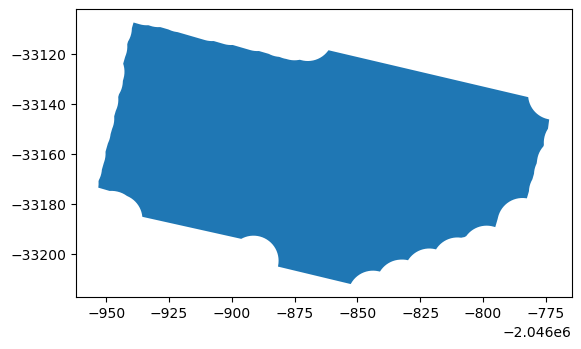

In [6]:
# load the panel polygons for comparison
gmseus_arrays = gpd.read_file('G:\\Data\\GMSEUS\\GMSEUS\\GMSEUS_NAIP_Arrays.shp')

# print the first few rows of the data
print(gmseus_arrays.head())

# create a subset of the data 10 rows long
gmseus_arrays_subset = gmseus_arrays.head(1)

# plot the subset of the data
gmseus_arrays_subset.plot()
plt.show()


In [12]:

def explode_geometries(gdf):
    """
    Explode a GeoDataFrame so that each row contains only one polygon/multipolygon part.
    """
    exploded_gdf = gdf.explode(index_parts=True).reset_index(drop=True)
    return exploded_gdf



def calculate_pairwise_jaccard(shapefile_a, shapefile_b):
    # Load datasets
    gdf_a = gpd.read_file(shapefile_a)
    gdf_b = gpd.read_file(shapefile_b)
    
    # Explode geometries
    gdf_a_exploded = gdf_a.explode(index_parts=True).reset_index(drop=True)
    gdf_b_exploded = gdf_b.explode(index_parts=True).reset_index(drop=True)
    
    # Ensure CRS match
    if gdf_a_exploded.crs != gdf_b_exploded.crs:
        gdf_b_exploded = gdf_b_exploded.to_crs(gdf_a_exploded.crs)
    
    # Perform spatial join to find intersecting rows
    intersecting_pairs = gpd.sjoin(gdf_a_exploded, gdf_b_exploded, how="inner", predicate="intersects")
    
    # Add IDs to original datasets for tracking
    gdf_a_exploded['id_a'] = gdf_a_exploded.index
    gdf_b_exploded['id_b'] = gdf_b_exploded.index
    
    # Merge the intersecting pairs to get geometry pairs
    intersecting_pairs = intersecting_pairs.merge(
        gdf_b_exploded[['geometry', 'id_b']],
        left_on='index_right', right_index=True, suffixes=('_a', '_b')
    )
    
    # Calculate Jaccard index for each intersecting pair
    jaccard_results = []
    for _, row in intersecting_pairs.iterrows():
        geom_a = row['geometry_a']
        geom_b = row['geometry_b']
        
        # Calculate intersection and union
        intersection_area = geom_a.intersection(geom_b).area
        union_area = geom_a.union(geom_b).area
        
        # Calculate Jaccard index
        jaccard_index = intersection_area / union_area if union_area != 0 else 0
        
        # Store results
        jaccard_results.append({
            'id_a': row['id_a'],
            'id_b': row['id_b'],
            'jaccard_index': jaccard_index
        })
    
    # Convert results to DataFrame
    jaccard_df = pd.DataFrame(jaccard_results)
    
    return jaccard_df

In [8]:
# Explode the geometries
exploded_gmseus = explode_geometries(gmseus_arrays)

# Print the first few rows of the exploded data
print(exploded_gmseus.head())

   arrayID nativeID Source        area  instYr PnlSource  panelID  numPanels  \
0        0        0  CCVPV  106.764365  2018.0  existing   719587         25   
1        1     1568  CCVPV  221.753275  2018.0  existing   720805          4   
2        2   180011  CCVPV   85.285502  2015.0  existing   893196       1704   
3        2   180011  CCVPV   85.285502  2015.0  existing   893196       1704   
4        3    10000    OSM   92.299999     NaN    gmseus  2511288          8   

         pnlArea                                           geometry  
0    5722.924336  POLYGON ((-2046953.18 -33173.397, -2046953.138...  
1     986.133346  POLYGON ((-2059299.539 33325.627, -2059299.524...  
2  155990.402240  POLYGON ((-2181290.313 245796.767, -2181279.16...  
3  155990.402240  POLYGON ((-2180965.63 246104.307, -2180959.91 ...  
4    1435.099913  POLYGON ((1795489.97 961952.324, 1795490.142 9...  


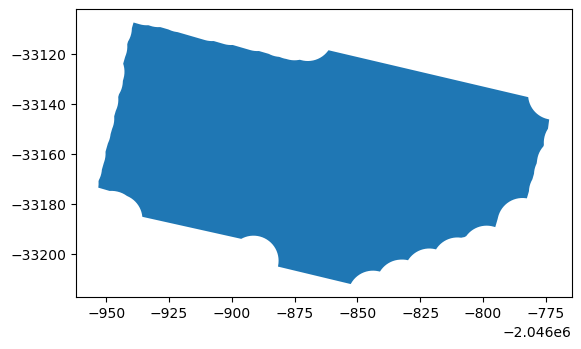

In [9]:
# Get the first few rows of the exploded data
exploded_gmseus_subset = exploded_gmseus.head(1)

# Plot the exploded data
exploded_gmseus_subset.plot()
plt.show()


  nativeID  instYr  cap_mw       area    modType AVtype  azimuth        mount  \
0   401476    2016   100.2  1735134.0       c-si   None    180.0  single_axis   
1   401865    2017    12.7   187820.0  thin-film   None    180.0  single_axis   
2   401866    2017     9.7    39717.0  thin-film   None    180.0         None   
3   402674    2017    12.5   194595.0       c-si   None    180.0  single_axis   
4   401807    2017   116.9  1881927.0       c-si   None    180.0  single_axis   

   Source                                           geometry  
0  USPVDB  MULTIPOLYGON Z (((738788.612 -265689.712 0, 73...  
1  USPVDB  MULTIPOLYGON Z (((971961.129 -636561.614 0, 97...  
2  USPVDB  MULTIPOLYGON Z (((925171.423 -384591.972 0, 92...  
3  USPVDB  MULTIPOLYGON Z (((853104.416 -280973.172 0, 85...  
4  USPVDB  MULTIPOLYGON Z (((985679.478 -461141.159 0, 98...  
  nativeID  instYr  cap_mw       area    modType AVtype  azimuth        mount  \
0   401476    2016   100.2  1735134.0       c-si   Non

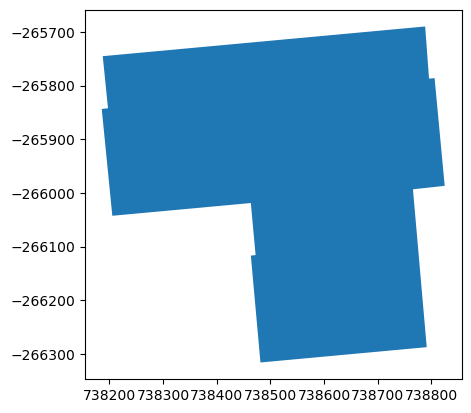

In [10]:
uspvdb_arrays = gpd.read_file('G:\\Data\\GMSEUS\\intermediateProducts\\uspvdb_poly.shp')
print(uspvdb_arrays.head())

# Explode the geometries
exploded_uspvdb = explode_geometries(uspvdb_arrays)

# Print the first few rows of the exploded data
print(exploded_uspvdb.head())

# Get the first few rows of the exploded data
exploded_uspvdb_subset = exploded_uspvdb.head(1)

# Plot the exploded data
exploded_uspvdb_subset.plot()
plt.show()

In [ ]:
#

In [21]:
def calculate_pairwise_jaccard_with_areas(shapefile_a, shapefile_b):
    # Load datasets
    gdf_a = gpd.read_file(shapefile_a)
    gdf_b = gpd.read_file(shapefile_b)
    
    # Explode geometries
    gdf_a_exploded = gdf_a.explode(index_parts=True).reset_index()
    gdf_b_exploded = gdf_b.explode(index_parts=True).reset_index()
    
    # Ensure GeoDataFrame and geometry column are valid
    if 'geometry' not in gdf_a_exploded.columns:
        gdf_a_exploded = gdf_a_exploded.set_geometry('geometry')
    if 'geometry' not in gdf_b_exploded.columns:
        gdf_b_exploded = gdf_b_exploded.set_geometry('geometry')
    
    # Add IDs and calculate areas for tracking
    gdf_a_exploded['id_a'] = gdf_a_exploded.index
    gdf_a_exploded['area_a'] = gdf_a_exploded.geometry.area  # Calculate areas
    gdf_b_exploded['id_b'] = gdf_b_exploded.index
    gdf_b_exploded['area_b'] = gdf_b_exploded.geometry.area  # Calculate areas

    # Ensure CRS match
    if gdf_a_exploded.crs != gdf_b_exploded.crs:
        gdf_b_exploded = gdf_b_exploded.to_crs(gdf_a_exploded.crs)
    
    # Perform spatial join to find intersecting rows
    intersecting_pairs = gpd.sjoin(
        gdf_a_exploded[['id_a', 'geometry', 'area_a']],
        gdf_b_exploded[['id_b', 'geometry', 'area_b']],
        how="inner",
        predicate="intersects"
    )
    
    # Merge geometries for Jaccard calculation
    intersecting_pairs = intersecting_pairs.merge(
        gdf_b_exploded[['id_b', 'geometry', 'area_b']],
        on='id_b',
        suffixes=('_a', '_b')
    )
    
    # Rename columns for clarity and prevent suffix issues
    intersecting_pairs.rename(columns={
        'geometry': 'geometry_a',
        'geometry_b': 'geometry_b',
        'area_b_b': 'area_b'  # Ensuring `area_b` is correctly named
    }, inplace=True)
    
    # Debugging: Check final columns
    print("Final Intersecting Pairs Columns:", intersecting_pairs.columns)
    
    # Calculate Jaccard index for each intersecting pair
    jaccard_results = []
    for _, row in intersecting_pairs.iterrows():
        geom_a = row['geometry_a']
        geom_b = row['geometry_b']
        
        # Calculate intersection and union
        intersection_area = geom_a.intersection(geom_b).area
        union_area = geom_a.union(geom_b).area
        
        # Calculate Jaccard index
        jaccard_index = intersection_area / union_area if union_area != 0 else 0
        
        # Store results, including areas
        jaccard_results.append({
            'id_a': row['id_a'],
            'id_b': row['id_b'],
            'area_a': row['area_a'],
            'area_b': row['area_b'],
            'intersection_area': intersection_area,
            'union_area': union_area,
            'jaccard_index': jaccard_index
        })
    
    # Convert results to DataFrame
    jaccard_df = pd.DataFrame(jaccard_results)
    
    return jaccard_df

# Example usage
shapefile_a = "G:\\Data\\GMSEUS\\GMSEUS\\GMSEUS_NAIP_Arrays.shp"
shapefile_b = "G:\\Data\\GMSEUS\\intermediateProducts\\uspvdb_poly.shp"

jaccard_df = calculate_pairwise_jaccard_with_areas(shapefile_a, shapefile_b)

Final Intersecting Pairs Columns: Index(['id_a', 'geometry_a', 'area_a', 'index_right', 'id_b', 'area_b_a',
       'geometry_b', 'area_b'],
      dtype='object')


   id_a  id_b  jaccard_index
0  2997  3023       0.876833
1  2998  3272       0.944767
2  2999  4982       0.901534
3  3000  7611       0.852369
4  3001  7699       0.883950


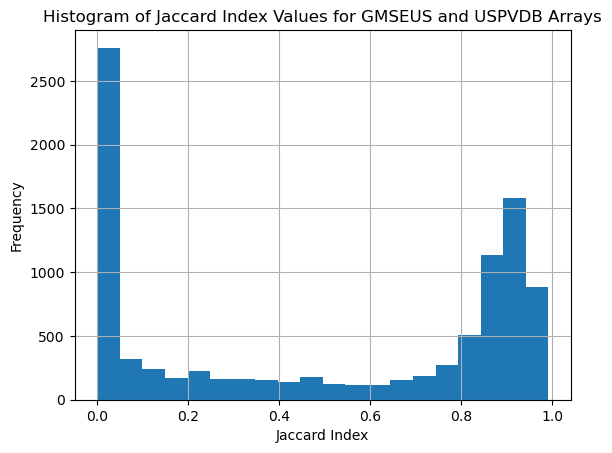

In [17]:
print(jaccard_df.head())

# plot a histogram of the Jaccard index values
jaccard_df['jaccard_index'].hist(bins=20)
plt.xlabel('Jaccard Index')
plt.ylabel('Frequency')
plt.title('Histogram of Jaccard Index Values for GMSEUS and USPVDB Arrays')
plt.show()

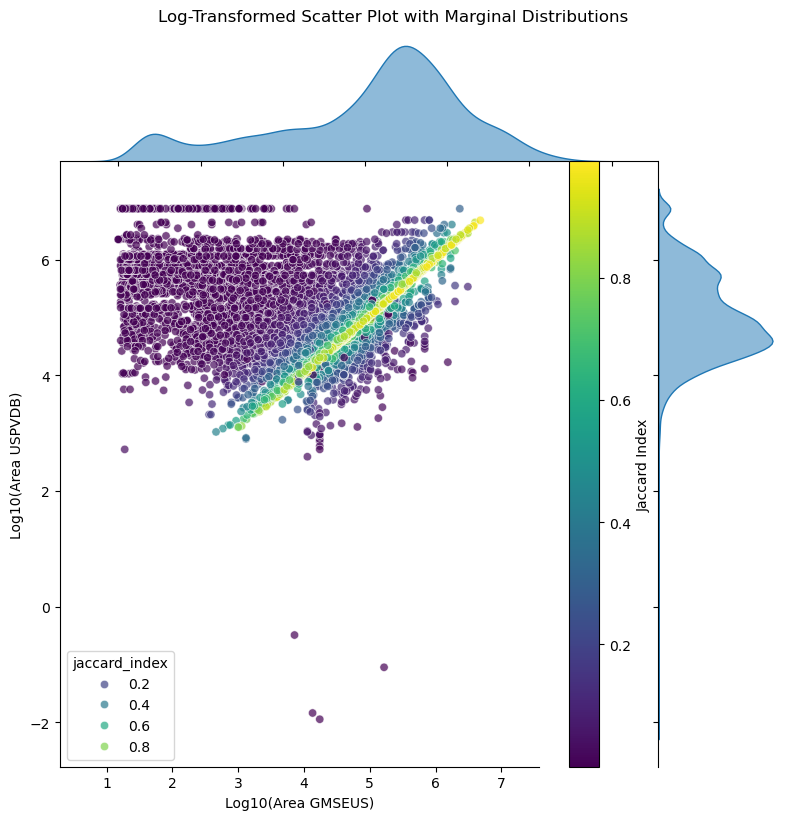

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def scatter_with_log_marginals(jaccard_df):
    # Apply log transformation to the area columns
    jaccard_df['log_area_a'] = np.log10(jaccard_df['area_a'])
    jaccard_df['log_area_b'] = np.log10(jaccard_df['area_b'])
    
    # Set up the grid
    g = sns.JointGrid(data=jaccard_df, x="log_area_a", y="log_area_b", space=0, height=8)
    
    # Scatter plot in the center
    g.plot_joint(
        sns.scatterplot,
        hue=jaccard_df['jaccard_index'],
        palette='viridis',
        alpha=0.7
    )
    
    # KDE plots on the margins
    g.plot_marginals(sns.kdeplot, fill=True, alpha=0.5)
    
    # Customize color bar for Jaccard index
    norm = plt.Normalize(jaccard_df['jaccard_index'].min(), jaccard_df['jaccard_index'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    cbar = g.fig.colorbar(sm, ax=g.ax_joint, orientation="vertical", label="Jaccard Index")
    
    # Set labels and title
    g.set_axis_labels("Log10(Area GMSEUS)", "Log10(Area USPVDB)")
    g.fig.suptitle("Log-Transformed Scatter Plot with Marginal Distributions", y=1.02)
    plt.show()

# Example usage
scatter_with_log_marginals(jaccard_df)

In [ ]:
import os

def create_combined_boxplot(dataframe, columns_list, title, output_folder, dpi=300, title_fontsize=20):
    """
    Creates a combined boxplot for given variables over years on the same plot, allowing both 'gof' and 'jaccard' metrics
    to be plotted and distinguished in the legend. Incorporates renaming of the columns for appearances.

    :param dataframe: Pandas DataFrame containing the data.
    :param columns_list: List of strings representing the base of column names to be plotted.
    :param title: The title of the plot.
    :param output_folder: The folder where the plot will be saved.
    :param dpi: The resolution of the saved plot in dots per inch.
    :param title_fontsize: The font size of the plot title.
    """
    # Initialize an empty DataFrame for the combined melted data
    combined_df_melted = pd.DataFrame()

    # Dictionary for renaming the variables for the legend
    rename_dict = {
        'aim_irrMapper_gof': 'AIM-HPA & IrrMapper (GOF)',
        'aim_lanid_gof': 'AIM-HPA & LANID (GOF)',
        'irrMapper_lanid_gof': 'IrrMapper & LANID (GOF)',
        'all_gof': 'All 3 (GOF)',
        'aim_irrMapper_jaccard': 'AIM-HPA & IrrMapper (Jaccard)',
        'aim_lanid_jaccard': 'AIM-HPA & LANID (Jaccard)',
        'irrMapper_lanid_jaccard': 'IrrMapper & LANID (Jaccard)'
    }

    for base_name in columns_list:
        # Filter columns matching the base name and extract the year
        relevant_columns = [col for col in dataframe.columns if base_name in col]
        for col in relevant_columns:
            # Extract the year from the column name
            parts = col.split('_')
            year = parts[-1]  # Assumes year is the last part of the column name

            # Prepare a temporary DataFrame for melting
            temp_df = dataframe[['system:index', col]].rename(columns={col: 'value'})
            temp_df['Year'] = year
            # Determine the renamed variable for the legend
            renamed_variable = rename_dict.get(base_name, base_name)  # Fallback to base_name if not found in dict
            temp_df['variable'] = renamed_variable

            # Adding the melted data to the combined DataFrame
            combined_df_melted = pd.concat([combined_df_melted, temp_df], axis=0)

    # Ensure 'Year' is of type int for correct plotting
    combined_df_melted['Year'] = combined_df_melted['Year'].astype(int)

    # Plotting
    plt.figure(figsize=(12, 8), dpi=dpi)
    sns.boxplot(x='Year', y='value', hue='variable', data=combined_df_melted)
    plt.title(title, fontsize=title_fontsize)
    plt.xlabel('Year')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.legend(title='Products')

    # Check if output folder exists, if not, create it
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Construct file path
    file_name = title.replace(' ', '_').replace('\n', '_').lower() + '.png'
    file_path = os.path.join(output_folder, file_name)

    # Save the figure
    plt.savefig(file_path, dpi=dpi)
    plt.show()  # Show the plot for visual confirmation
    plt.close()  # Close the figure to free up memory

    print(f"Plot saved to {file_path}")
    
# Using the function to create a combined boxplot for both 'aim_irrMapper_gof' and 'aim_lanid_gof'
create_combined_boxplot(data, ['aim_irrMapper_gof', 'aim_lanid_gof', 'irrMapper_lanid_gof', 'all_gof'], 'Boxplots of Goodness of Fit (GOF) \n for 30m Irrigation Products through time', 'Z:\\PHD_Work\\2024\\AGU_Chapman\\Poster_Conference\\')